In [10]:
# GET PARAMETERS
import os 
import sys
import pandas as pd
import matplotlib.pyplot as plt 
import torch 
import pickle
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from examples.load_best_config import get_trainer_and_ds_from_saved_trial,load_trainer_ds_from_saved_trial
from constants.paths import SAVE_DIRECTORY
from plotting.plotting import get_gain_from_mod1,get_y_size_from_temporal_agg,plot_coverage_matshow,get_df_mase_and_gains,gain_between_models,get_df_gains

def get_previous_and_prediction(trainer1,trainer2,ds1,ds2,training_mode,step_ahead,step_ahead_max):
    full_predict1,Y_true,_ = trainer1.testing(ds1.normalizer, training_mode =training_mode)
    full_predict2,_,_ = trainer2.testing(ds2.normalizer, training_mode =training_mode)

    inputs = [[x,y,x_c] for  x,y,x_c in ds1.dataloader[training_mode]]
    X = torch.cat([x for x,_,_ in inputs],0)
    X = ds1.normalizer.unormalize_tensor(inputs = X,feature_vect = True) # unormalize input cause prediction is unormalized 

    previous = X[:,:,-(step_ahead_max+1-step_ahead)]
    predict1 = full_predict1[:,:,step_ahead-1]
    predict2 = full_predict2[:,:,step_ahead-1]
    real = Y_true[:,:,step_ahead-1]
    return previous,predict1,predict2,real


def plot_gain_between_models_with_temporal_agg(ds,dic_error,stations,temporal_aggs,training_mode,metrics):
    for metric in metrics:
        if len(temporal_aggs) == 1:
            fig, axes = plt.subplots(1, 2, figsize=(max(8,0.5*len(stations)),6))
        else:
            if temporal_aggs == ['hour','date','weekday']:
                gridspec_kw={'width_ratios': [1,5],'height_ratios': [4,3,2]}
            else:
                gridspec_kw={'width_ratios': [1,5],'height_ratios': [1]*len(temporal_aggs)}
            
            fig, axes = plt.subplots(len(temporal_aggs), 2, figsize=(max(8,0.5*len(stations)),6*len(temporal_aggs)),gridspec_kw=gridspec_kw)
    
        for i,temporal_agg in enumerate(temporal_aggs):
            if metric == 'mase':
                df_mase1,df_mase2,df_gain21 = get_df_mase_and_gains(ds,dic_error,training_mode,temporal_agg,stations)
            else:
                df_gain21 = get_df_gains(ds,dic_error,metric,training_mode,temporal_agg,stations)
            # agg All sations  
            if len(temporal_aggs) == 1:
                plt.sca(axes[0])
            else:
                plt.sca(axes[i,0])
            plot_coverage_matshow(pd.DataFrame(pd.DataFrame(df_gain21).mean(axis=1)),cmap = 'RdYlBu', save=None, 
                                cbar_label=f'{metric.upper()} Gain (%)',bool_reversed=True,v_min=-10,v_max=10)
            title = f'Average {metric.upper()} Gain(%) per {temporal_agg} of \nModel2 compared to Model1\nAggregated through stations'
            if len(temporal_aggs) == 1:
                axes[0].set_title(title)
            else:
                axes[i,0].set_title(title)

            # Per station 
            if len(temporal_aggs) == 1:
                plt.sca(axes[1])
            else:
                plt.sca(axes[i,1])
            plot_coverage_matshow(pd.DataFrame(df_gain21),cmap = 'RdYlBu', save=None, 
                                cbar_label=f'{metric.upper()} Gain (%)',bool_reversed=True,v_min=-20,v_max=20)
            title = f'Average {metric.upper()} Gain(%) per {temporal_agg} of \nModel2 compared to Model1'
            if len(temporal_aggs) == 1:
                axes[1].set_title(title)
            else:
                axes[i,1].set_title(title) 



## Load 2 trained models:

In [2]:
print('Current position: ',os.getcwd())

modification = {'shuffle':False,
                'data_augmentation':False
                }

save_path =  f"{SAVE_DIRECTORY}/K_fold_validation"
if_hp_tuning = 'training_wo_HP_tuning' # or 'training_with_HP_tuning'
path_model_args = f"{save_path}/{if_hp_tuning}/best_models"
model_args = pickle.load(open(f"{path_model_args}/model_args.pkl", 'rb'))



## Best model STAEformer WITHOUT NetMob:
trial_id1 = 'subway_in_calendar_STAEformer_HuberLossLoss_2025_06_17_14_30_17612_F6_f5'
args = model_args['model'][trial_id1]['args']
model_save_path = f"{path_model_args}/{trial_id1}.pkl"
trainer1, ds1, args_init1 = load_trainer_ds_from_saved_trial(args,model_save_path,modification = modification)

## Best model STAEformer NetMob POIs:
trial_id2 = 'subway_in_calendar_netmob_POIs_STAEformer_HuberLossLoss_2025_06_17_11_32_17612_F6_f5'
args = model_args['model'][trial_id2]['args']
model_save_path = f"{path_model_args}/{trial_id2}.pkl"
trainer2, ds2, args_init2 = load_trainer_ds_from_saved_trial(args,model_save_path,modification = modification)

Current position:  /home/rrochas/prediction-validation
----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 7392 elts between 2019-03-16 00:00:00 and 2019-05-31 23:45:00
Invalid dates within this fold: 776

>>>Tackle Target dataset: subway_in
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_in/subway_in.csv
   Init Dataset: 'torch.Size([7392, 40]). 0 Nan values
   TRAIN contextual_ds: torch.Size([2819, 40, 7])
   VALID contextual_ds: torch.Size([940, 40, 7])
   TEST contextual_ds: torch.Size([939, 40, 7])

 Loading calendar inputs ...
Init U/Utarget size: torch.Size([4699, 40, 7])/torch.Size([4699, 40, 4]) Train/Valid/Test 2819 940 939

----------------------------------------
Loading the dataset for fold n°5
Model size: 0.001GB
----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 7392 elts between 2019-03-16 00:00:00 and 2019-05-31 23:45:00
Inv

## Compare 2 models: 

In [3]:
training_mode = 'test'
min_flow = 20
step_ahead = args_init1.step_ahead
step_ahead_max = args_init1.step_ahead

previous,predict1,predict2,real = get_previous_and_prediction(trainer1,trainer2,ds1,ds2,training_mode,step_ahead,step_ahead_max)
dic_gain,dic_error = get_gain_from_mod1(real,predict1,predict2,previous,min_flow,metrics = ['mse','mae','mape'],acceptable_error= 0,mape_acceptable_error=0)

Model1 correspond to :  subway_in_calendar_STAEformer_HuberLossLoss_2025_06_17_14_30_17612_F6_f5
Model2 correspond to :  subway_in_calendar_netmob_POIs_STAEformer_HuberLossLoss_2025_06_17_11_32_17612_F6_f5


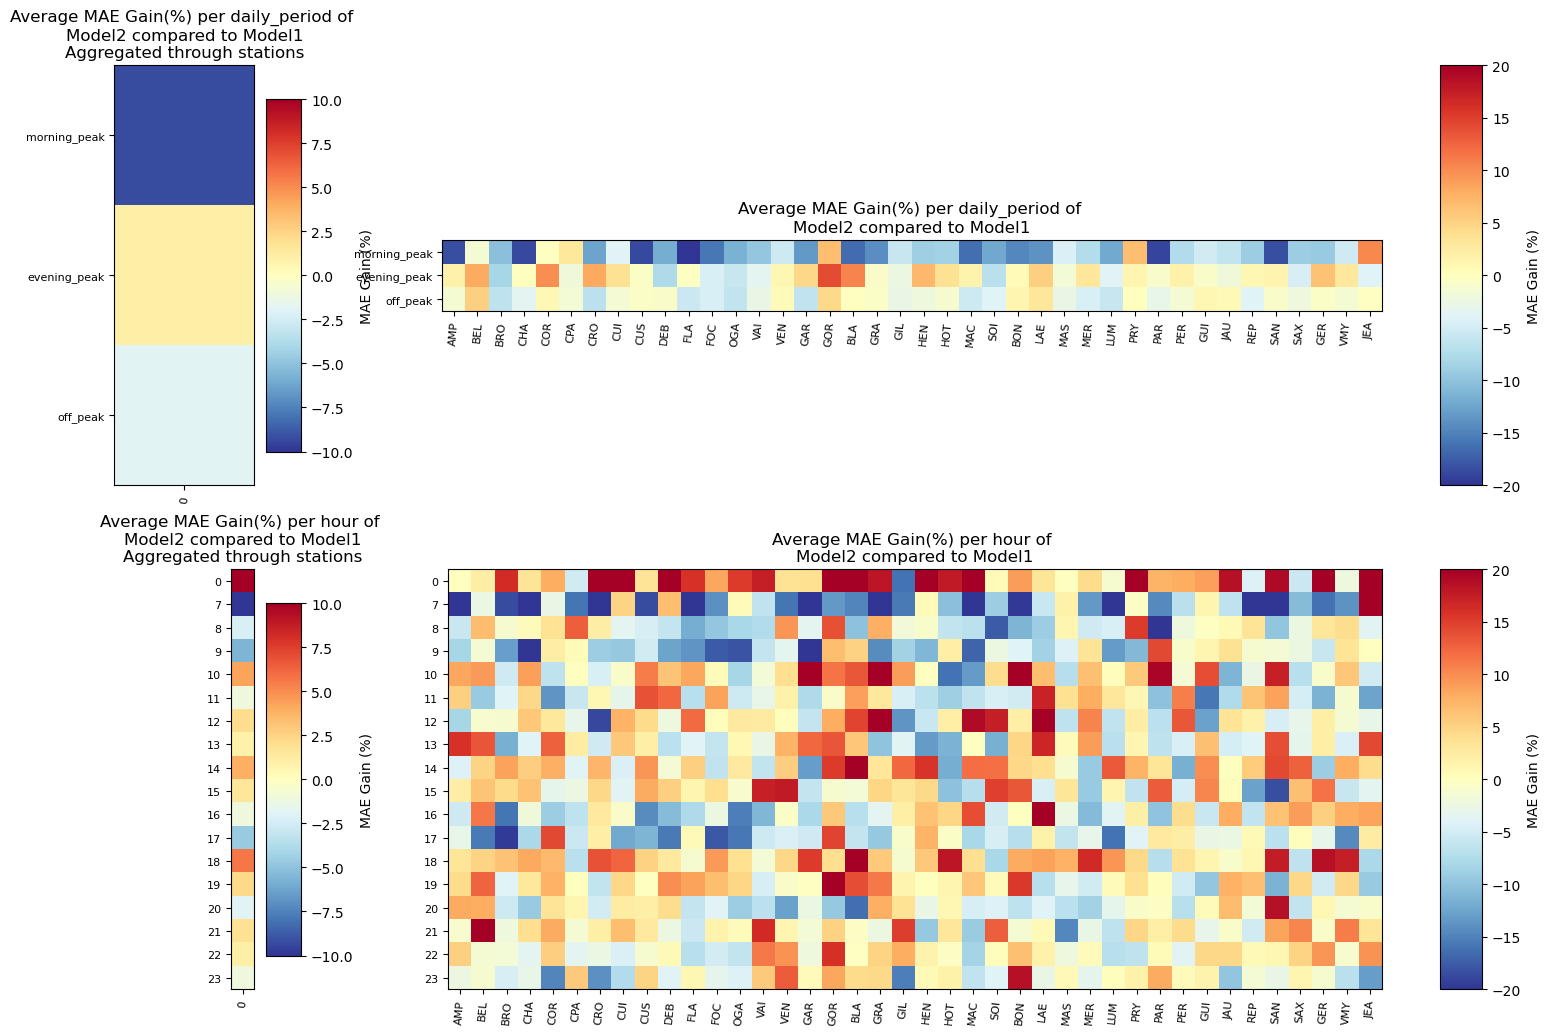

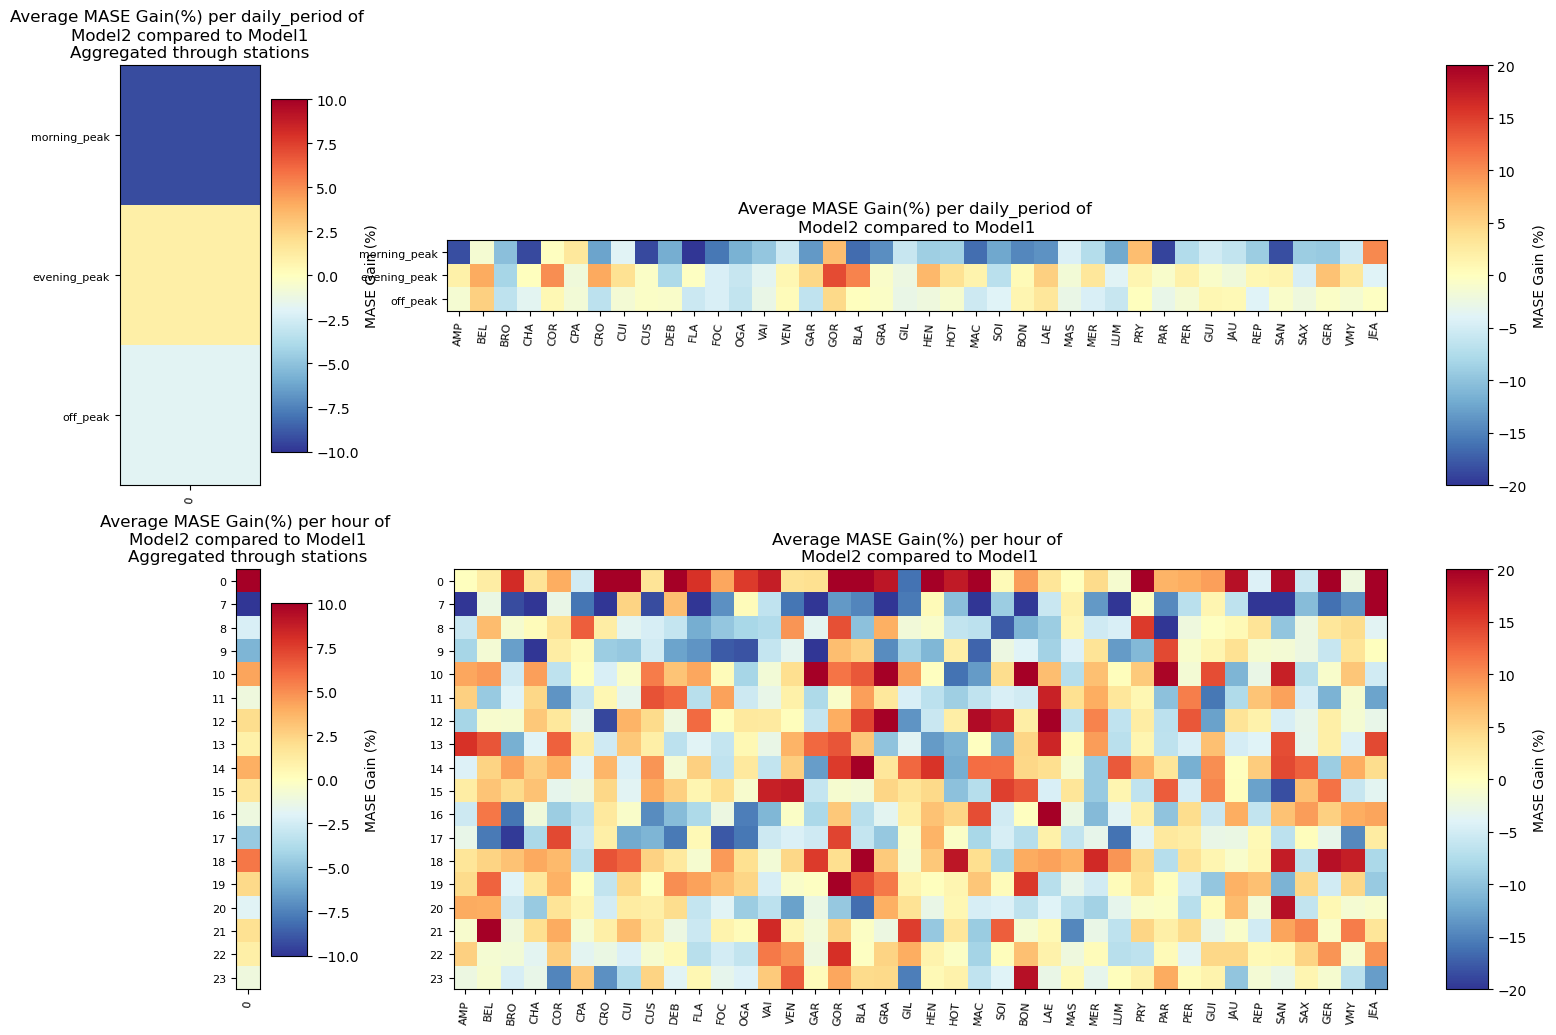

In [11]:
temporal_aggs =  ['daily_period','hour'] # ['hour','date','weekday'] 'hour', 'date', 'weekday', 'weekday_hour', 'weekday_hour_minute', 'daily_period', 'working_day_hour'
stations = list(ds1.spatial_unit)  # ['BEL','PER','PAR','AMP','FOC'] #list(ds1.spatial_unit)
plot_gain_between_models_with_temporal_agg(ds1,dic_error,stations,temporal_aggs,training_mode,metrics = ['mae','mase'])
print('Model1 correspond to : ',trial_id1)
print('Model2 correspond to : ',trial_id2)

In [24]:
import numpy as np 
import pandas as pd
import torch
from bokeh.plotting import figure, show,output_notebook
from bokeh.models import Legend

# Personnal imports: 
from constants.paths import SAVE_DIRECTORY 
from PI.PI_object import PI_object

station = 'PER'
station_i = list(ds1.spatial_unit).index(station)


title = f'Comparison of prediction of {station} between two models'
p = figure(title=title,x_axis_type='datetime', x_axis_label='Time', y_axis_label='Demand volume', width=900, height=400)
p.add_layout(Legend(), 'right')

df_verif = ds1.tensor_limits_keeper.df_verif_test.copy()


# Predicted Values
p.line(df_verif.iloc[:,-1], predict1[:,station_i].cpu().numpy(), 
    legend_label=f"predict1", 
    line_dash="dashed", line_width=1, color="green")

p.line(df_verif.iloc[:,-1], predict2[:,station_i].cpu().numpy(), 
    legend_label=f"predict2", 
    line_dash="dashed", line_width=1, color="red")

p.line(df_verif.iloc[:,-1], real[:,station_i].cpu().numpy(), legend_label="True Value", line_width=2, color="blue")
output_notebook()
show(p)

Loading BokehJS ...

## Load all pickle save and only look at usefull ones:

In [ ]:
modification = {'shuffle':False,
                'data_augmentation':False
                'freq':'15min'}

# Load Model1:
save_folder1 = 'K_fold_validation/training_with_HP_tuning/re_validation'
add_name_id1 = ''
trial_id1 ='subway_in_STGCN_MSELoss_2025_01_20_14_27_20569'
trainer1,ds1,args1 = get_trainer_and_ds_from_saved_trial(trial_id1,add_name_id1,save_folder1,modification)

# Fine Tune Model1: 


# Get Pred1,Pred2, TrueValues:
training_mode = 'test'
min_flow = 20

previous,predict1,predict2,real = get_previous_and_prediction(trainer1,trainer2,ds1,ds2,training_mode)
dic_gain,dic_error = get_gain_from_mod1(real,predict1,predict2,previous,min_flow,metrics = ['mse','mae','mape'],acceptable_error= 0,mape_acceptable_error=0)

temporal_aggs = ['hour','date','weekday']
stations = list(ds1.spatial_unit)  # ['BEL','PER','PAR','AMP','FOC'] #list(ds1.spatial_unit)


plot_gain_between_models_with_temporal_agg(ds1,dic_error,stations,temporal_aggs,training_mode)

In [ ]:
import pickle
model_args = pickle.load(open('save/best_models/model_args.pkl','rb'))

list_trained_models = list(model_args['model'].keys())


model_to_remove = []
remaining_models = []
remaining_epochs = []
for model_name in list_trained_models:
    epochs = model_args['model'][model_name]['performance']['epoch']
    if (epochs < 20) or not(model_args['model'][model_name]['performance']['training_over']):
        model_to_remove.append(model_name)
    else:
        remaining_models.append(model_name)
        remaining_epochs.append(epochs)

print('Percentage of models to remove:','{:.2%}'.format(len(model_to_remove)/len(list_trained_models)))



Percentage of models to remove: 18.93%


## Find best recorded models :

In [72]:
import numpy as np 

STGCN_subway_in_netmob_calendar = [c for c in remaining_models if 'subway_in_calendar_embedding_netmob_POIs_STGCN_TE' in c]
STGCN_subway_in_calendar = [c for c in remaining_models if 'subway_in_calendar_embedding_STGCN_TE' in c]

STAEformer_subway_calendar = [c for c in remaining_models if 'subway_in_calendar_STAEformer' in c]
STAEformer_subway_in_netmob_calendar = [c for c in remaining_models if 'subway_in_calendar_netmob_POIs_STAEformer' in c]

print('len(STGCN_subway_in_netmob_calendar):',len(STGCN_subway_in_netmob_calendar))
print('len(STGCN_subway_in_calendar):',len(STGCN_subway_in_calendar))
print('len(STAEformer_subway_calendar):',len(STAEformer_subway_calendar))
print('len(STAEformer_subway_in_netmob_calendar):',len(STAEformer_subway_in_netmob_calendar))   

## Identify the best model for each type:
dic_best_model = {}
for list_model_ids in [STGCN_subway_in_netmob_calendar, STGCN_subway_in_calendar, STAEformer_subway_calendar, STAEformer_subway_in_netmob_calendar]:
    best_test_mae = np.inf 
    for c in list_model_ids:
        step_ahead = model_args['model'][c]['args']['step_ahead']

        valid_loss = model_args['model'][c]['performance']['valid_loss']
        test_mae =  model_args['model'][c]['performance']['test_metrics']['mae_all']

        if (test_mae < best_test_mae) and (step_ahead == 4):
            best_test_mae = test_mae
            best_model_ = c
            best_model_args = model_args['model'][c]['args']

    dic_best_model[best_model_] = best_model_args

    


for c in dic_best_model.keys():
    print('\nBest Model: ',c)
    print('   valid Loss:', model_args['model'][c]['performance']['valid_loss'])
    print('   RMSE / MAE / MASE :',model_args['model'][c]['performance']['test_metrics']['rmse_all'],
          model_args['model'][c]['performance']['test_metrics']['mae_all'],
          model_args['model'][c]['performance']['test_metrics']['mase_all'])
    


len(STGCN_subway_in_netmob_calendar): 21
len(STGCN_subway_in_calendar): 88
len(STAEformer_subway_calendar): 45
len(STAEformer_subway_in_netmob_calendar): 145

Best Model:  subway_in_calendar_embedding_netmob_POIs_STGCN_TE_HuberLossLoss_2025_05_29_13_31_17612_F6_f0
   valid Loss: 22.061961932892494
   RMSE / MAE / MASE : 39.54457187652588 22.149127960205078 0.6932779848575592

Best Model:  subway_in_calendar_embedding_STGCN_TE_HuberLossLoss_2025_06_16_15_07_74240_F6_f3
   valid Loss: 22.30528481666078
   RMSE / MAE / MASE : 36.849599838256836 21.206647872924805 0.6612226665019989

Best Model:  subway_in_calendar_STAEformer_HuberLossLoss_2025_06_10_17_46_17612_F6_f0
   valid Loss: 23.21443708703873
   RMSE / MAE / MASE : 39.62387466430664 22.299235343933105 0.6979794651269913

Best Model:  subway_in_calendar_netmob_POIs_STAEformer_HuberLossLoss_2025_06_16_17_44_61397_F6_f3
   valid Loss: 29.475637801150057
   RMSE / MAE / MASE : 38.75483322143555 22.030150413513184 0.6862529665231705


# Load Both models to compare : 

In [2]:
modification = {'shuffle':False,
                'data_augmentation':False
                'freq':'15min'}

# Load Model1:
save_folder1 = 'K_fold_validation/training_with_HP_tuning/re_validation'
add_name_id1 = ''
trial_id1 ='subway_in_STGCN_MSELoss_2025_01_20_14_27_20569'
trainer1,ds1,args1 = get_trainer_and_ds_from_saved_trial(trial_id1,add_name_id1,save_folder1,modification)

# Load Model2: 
#Trained Model with Subway-in / Subway-out 
if False:
    save_folder2 = 'K_fold_validation/training_with_HP_tuning/re_validation'
    add_name_id2 = 'concat_early'
    trial_id2 ='subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_20_05_38_87836' 
    trainer2,ds2,args2 = get_trainer_and_ds_from_saved_trial(trial_id2,add_name_id2,save_folder2,modification)

#Trained Model with Subway-in / NetMob POI:
if False: 
    save_folder2 = 'K_fold_validation/training_with_HP_tuning/re_validation'
    #add_name_id2 = 'NETMOB_POIS_maps_Twitter_concat_early_late_UL_DL_all_tags'
    add_name_id2 = 'NETMOB_POIS_maps_Deezer_concat_early_DL_IRIS'
    trial_id2 ='subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_20_05_38_87836' 
    trainer2,ds2,args2 = get_trainer_and_ds_from_saved_trial(trial_id2,add_name_id2,save_folder2,modification)

>>>>Model: STGCN; K_fold = 6; Loss function: MSE 


Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 2821 940 940

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Invalid dates within this fold: 481

Init Dataset: 'torch.Size([4597, 40]) with 183880 Total nb of elements and 0 Nan values
Init U/Utarget size: torch.Size([2940, 40, 7])/torch.Size([2940, 40, 1]) Train/Valid/Test 1059 941 939

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Model size: 0.000GB
number of total parameters: 71713
number of trainable parameters: 71713


## Have a look on some interpolation:

In [3]:
# 'DA_method': 'magnitude_warping'
# 'DA_method': 'rich_interpolation'
# 'DA_method': 'interpolation'

modification = {'shuffle':False,
                'DA_method' : ['magnitude_warping','rich_interpolation'],
                'data_augmentation' : True 
                }


save_folder2 = 'K_fold_validation/training_with_HP_tuning/re_validation'
add_name_id2 = 'concat_early'
trial_id2 ='subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_20_05_38_87836' 
trainer2,ds2,args2 = get_trainer_and_ds_from_saved_trial(trial_id2,add_name_id2,save_folder2,modification)

training_mode = 'train'
inputs = [[x,y,x_c] for  x,y,x_c in ds2.dataloader[training_mode]]
nb_contextual_data = len(inputs[0][2])
X = torch.cat([x for x,_,_ in inputs],0).to(trainer2.args.device)
Y_true = torch.cat([y for _,y,_ in inputs],0).to(trainer2.args.device)
X_c = [torch.cat([x_c[k] for _,_,x_c in inputs],0).to(trainer2.args.device)  for k in range(nb_contextual_data)]
X_c_one = [torch.ones(x_c.size()).to(trainer2.args.device) for x_c in X_c]

>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
Invalid dates within this fold: 776



Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
vision_input_type POIs
vision_model_name VariableSelectionNetwork
2821 train samples had been added thank to Data Augmentation
calendar_dayofweek data augmented by duplication but not modified
calendar_hour data augmented by duplication but not modified
calendar_dayofweek data augmented by duplication but not modified
calendar_hour data augmented by duplication but not modified
calendar_dayofweek data augmented by duplication but not modified
calendar_hour data augmented by duplication but not modified
calendar_dayofweek data augmented by duplication but not modified
calendar_hour data augmented by duplication but not modified
calendar_dayofweek data augmented by duplication but not modified
calendar_hour data augmented by duplication but not modified
calendar_dayofweek data augmented by duplication but not modified
calendar_hour data augmented by duplication but not modified
calendar_dayofweek dat

<Axes: >

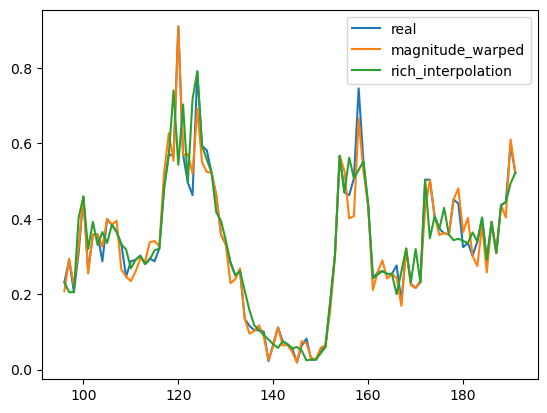

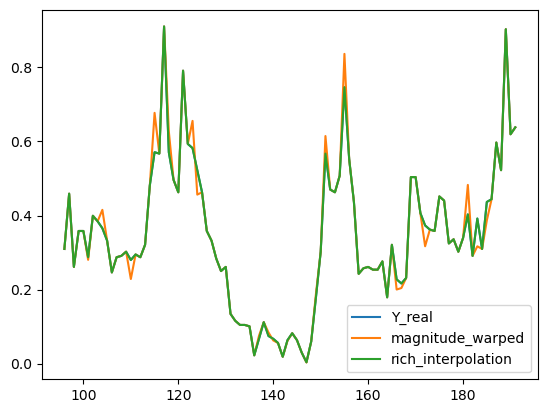

In [10]:
n = X.size(0)//3
station_i = 0

L = -3

pd.DataFrame({'real': X[:n,station_i,L].detach().cpu(),
              'magnitude_warped':X[n:2*n,station_i,L].detach().cpu(),
              'rich_interpolation':X[2*n:,station_i,L].detach().cpu(),
              }).iloc[96*1:96*2,:].plot()


pd.DataFrame({'Y_real': Y_true[:n,station_i,0].detach().cpu(),
              'magnitude_warped':Y_true[n:2*n,station_i,0].detach().cpu(),
               'rich_interpolation':Y_true[2*n:,station_i,0].detach().cpu(),
              }).iloc[96*1:96*2,:].plot()

## Get Metrics from trained model. Compared consistency with saved one : 
Nous permets de nous assurer qu'on à bien sauvegarder le meilleur model, et que c'est bien celui qu'on Load.

In [4]:
def display_consistency(trainer,ds,save_folder,trial_id,add_name_id,training_mode = 'test'):
    full_predict1,Y_true,_ = trainer.testing(ds.normalizer, training_mode =training_mode)
    Y_true= Y_true.detach().clone().reshape(-1)    
    full_predict1= full_predict1.detach().clone().reshape(-1)    
    error_pred1 = ((Y_true - full_predict1)**2).mean()

    df_metrics1 = pd.read_csv(f"{current_path}/{SAVE_DIRECTORY}/{save_folder}/METRICS_{trial_id}{add_name_id}.csv")
    display(df_metrics1)
    print(f"MSE errror on {training_mode} by loading trained model : {'{:.2f}'.format(error_pred1.item())}\n")

In [3]:
display_consistency(trainer1,ds1,save_folder1,trial_id1,add_name_id1,training_mode = 'test')
display_consistency(trainer2,ds2,save_folder2,trial_id2,add_name_id2,training_mode = 'test')

,Unnamed: 0,mse,mae,mape,VAR_mse,VAR_mae,VAR_mape,mse_complete_ds,mae_complete_ds,mape_complete_ds
0,valid,1250.633032,20.827599,34.545302,8210.072104,0.396348,11.819149,1157.247070,19.905209,30.030531
1,test,1306.318921,21.229312,33.583765,1632.788441,0.561886,37.853172,1319.264526,20.539398,28.160223


MSE errror on test by loading trained model : 1319.26



,Unnamed: 0,mse,mae,mape,VAR_mse,VAR_mae,VAR_mape,mse_complete_ds,mae_complete_ds,mape_complete_ds
0,valid,1230.919019,20.847181,36.719215,5382.383880,0.558646,6.967195,1128.664185,19.996849,33.227039
1,test,1288.185107,21.260062,36.229020,4998.188979,1.045187,84.935830,1286.441650,20.617752,29.995420


MSE errror on test by loading trained model : 1286.44



## Checking if Contetual Data are taken into account
- Set the Tensor associated to contextual data as 0 Tensor 
- Do the prediction 
- Compare the associated metrics

In [9]:
def check_impact_of_contextual_data(trainer,ds,training_mode = 'test'):
    inputs = [[x,y,x_c] for  x,y,x_c in ds.dataloader[training_mode]]
    nb_contextual_data = len(inputs[0][2])
    X = torch.cat([x for x,_,_ in inputs],0).to(trainer.args.device)
    Y_true = torch.cat([y for _,y,_ in inputs],0).to(trainer.args.device)
    X_c = [torch.cat([x_c[k] for _,_,x_c in inputs],0).to(trainer.args.device)  for k in range(nb_contextual_data)]
    X_c_one = [torch.ones(x_c.size()).to(trainer.args.device) for x_c in X_c]

    trainer.model.eval()
    with torch.no_grad():
        Preds = trainer.model(X,X_c)
        Preds_no_contextual = trainer.model(X,X_c_one)
        
    Preds = Preds.detach().cpu()
    Preds_no_contextual = Preds_no_contextual.detach().cpu()
    Y_true = Y_true.detach().cpu()
    Preds = ds.normalizer.unormalize_tensor(inputs = Preds,feature_vect = True).reshape(-1)     #  device = self.args.device
    Preds_no_contextual = ds.normalizer.unormalize_tensor(inputs = Preds_no_contextual,feature_vect = True).reshape(-1)     #  device = self.args.device
    Y_true = ds.normalizer.unormalize_tensor(inputs = Y_true,feature_vect = True).reshape(-1)     # device = self.args.device

    error_pred1 = ((Y_true - Preds)**2).mean()
    error_pred_contextual_null = ((Y_true - Preds_no_contextual)**2).mean()

    print(f"MSE errror on {training_mode} set by loading trained model :\nWith contectual data: {'{:.2f}'.format(error_pred1.item())}")
    print(f"Without contectual data: {'{:.2f}'.format(error_pred_contextual_null.item())}")
    print(f"Associated MSE Gain {'{:.1%}'.format(1-error_pred1.item()/error_pred_contextual_null.item())}")

check_impact_of_contextual_data(trainer2,ds2,training_mode = 'test')

MSE errror on test set by loading trained model :
With contectual data: 1286.44
Without contectual data: 2206.18
Associated MSE Gain 41.7%


## Production de Visuel :

In [4]:
# Get Pred1,Pred2, TrueValues:
training_mode = 'test'
min_flow = 20

previous,predict1,predict2,real = get_previous_and_prediction(trainer1,trainer2,ds1,ds2,training_mode)
dic_gain,dic_error = get_gain_from_mod1(real,predict1,predict2,previous,min_flow,metrics = ['mse','mae','mape'],acceptable_error= 0,mape_acceptable_error=0)

## Get Naiv Error and Model1 Error: 

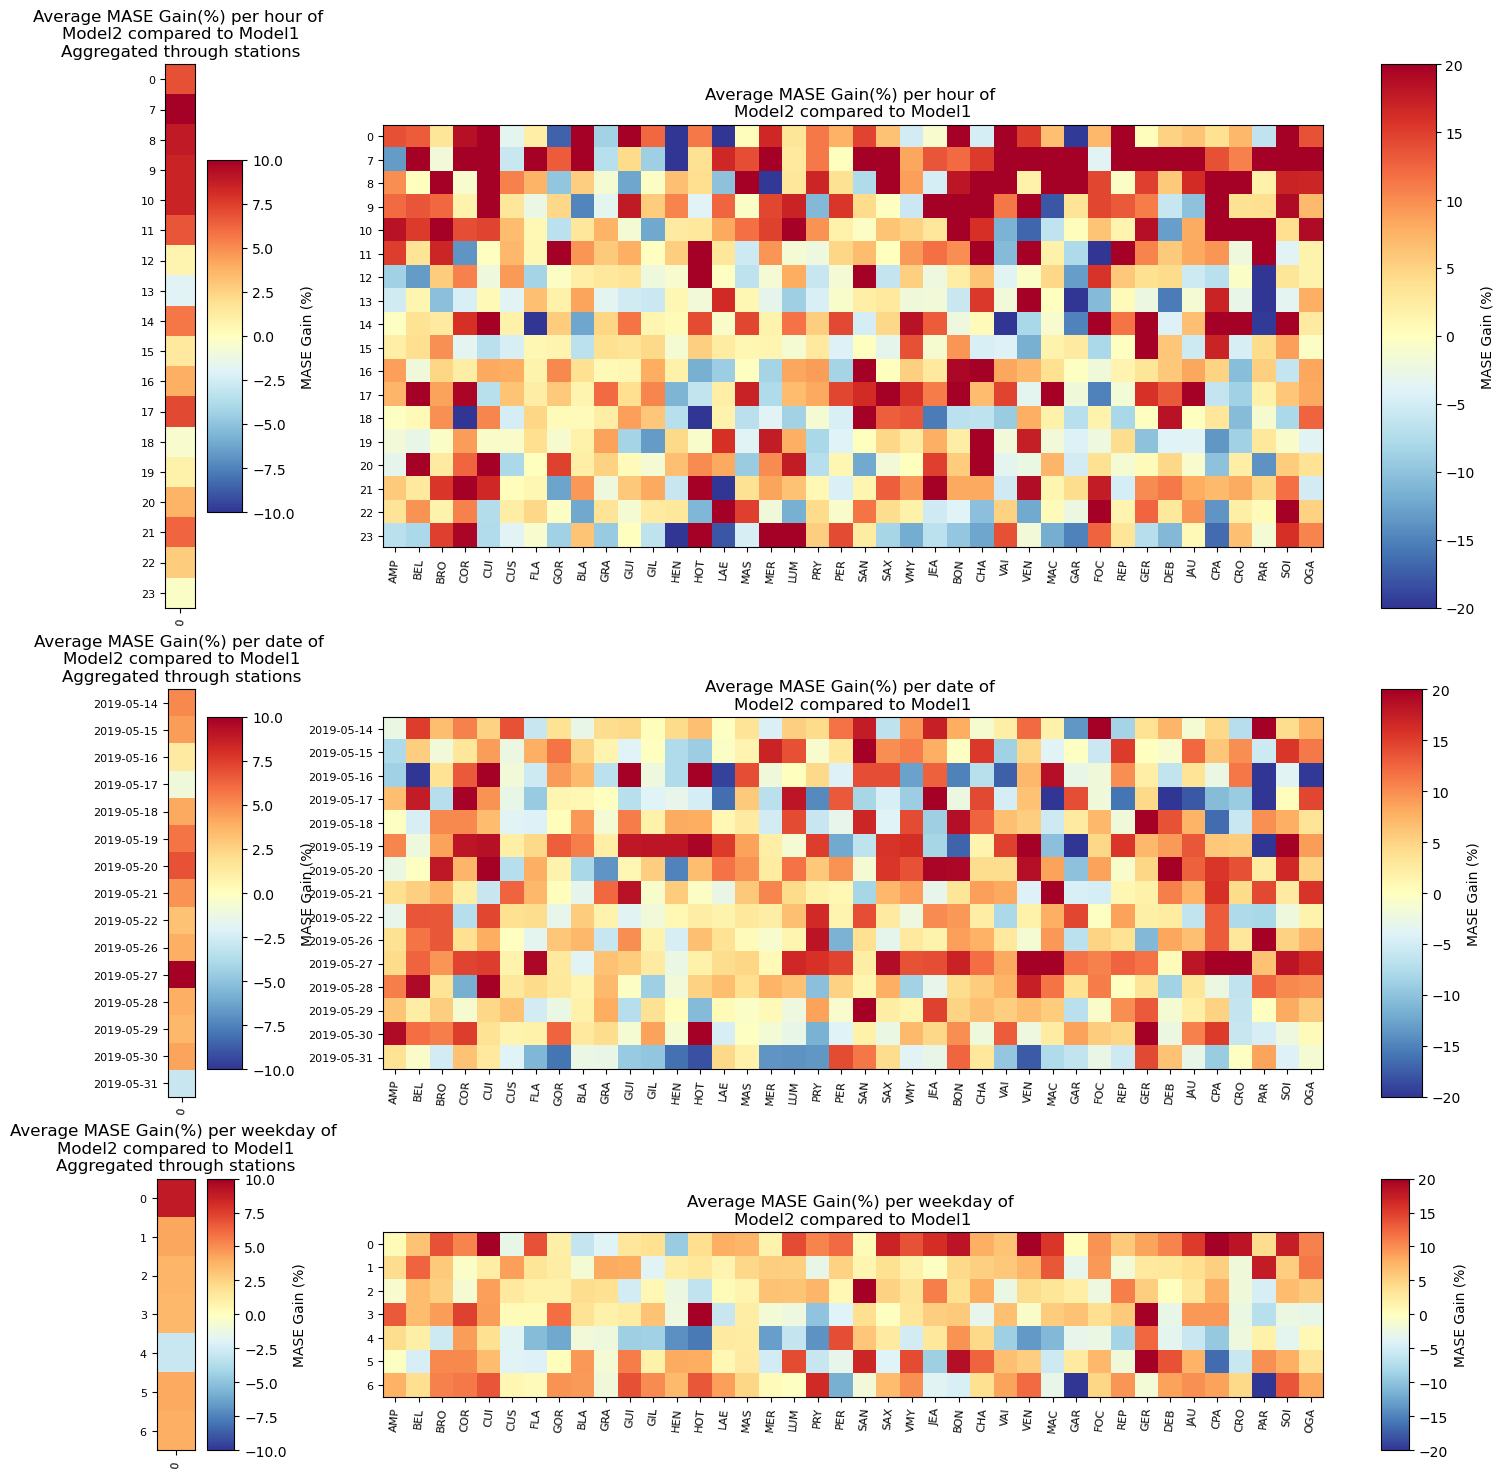

In [6]:
temporal_aggs = ['hour','date','weekday']
stations = list(ds1.spatial_unit)  # ['BEL','PER','PAR','AMP','FOC'] #list(ds1.spatial_unit)


plot_gain_between_models_with_temporal_agg(ds1,dic_error,stations,temporal_aggs,training_mode)

"""
fig, axes = plt.subplots(len(temporal_aggs), 2, figsize=(max(8,0.5*len(stations)),6*len(temporal_aggs)),gridspec_kw={'width_ratios': [1,5],'height_ratios': [4,3,2]})
for i,temporal_agg in enumerate(temporal_aggs):
    df_mase1,df_mase2,df_gain21 = get_df_mase_and_gains(ds1,dic_error,training_mode,temporal_agg,stations)
    # agg All sations  
    plt.sca(axes[i,0])
    plot_coverage_matshow(pd.DataFrame(pd.DataFrame(df_gain21).mean(axis=1)),cmap = 'RdYlBu', save=None, 
                        cbar_label='MASE Gain (%)',bool_reversed=True,v_min=-10,v_max=10)
    title = f'Average MASE Gain(%) per {temporal_agg} of \nModel2 compared to Model1\nAggregated through stations'
    axes[i,0].set_title(title)

    # Per station 
    plt.sca(axes[i,1])
    plot_coverage_matshow(pd.DataFrame(df_gain21),cmap = 'RdYlBu', save=None, 
                        cbar_label='MASE Gain (%)',bool_reversed=True,v_min=-20,v_max=20)
    title = f'Average MASE Gain(%) per {temporal_agg} of \nModel2 compared to Model1'
    axes[i,1].set_title(title) 
"""


## Plot Time Series on specific station: 

<Axes: >

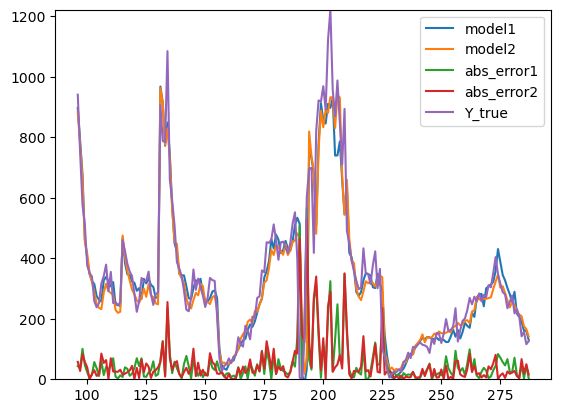

In [6]:
station = 'BEL'
start_day = 1
nb_days = 2


station_i = list(ds1.spatial_unit).index(station)
pred1 = predict1[:,station_i].numpy()
pred2 = predict2[:,station_i].numpy()
ytrue = real[:,station_i].numpy()

error_abs1 = dic_error['mae']['error_pred1'].reshape(-1,len(ds1.spatial_unit))[:,station_i]
error_abs2 = dic_error['mae']['error_pred2'].reshape(-1,len(ds1.spatial_unit))[:,station_i]
naive_error = dic_error['mae_naiv']['error_naiv'].reshape(-1,len(ds1.spatial_unit))[:,station_i]

ax = pd.DataFrame({'model1':pred1,
              'model2':pred2,
              'abs_error1':error_abs1,
              'abs_error2':error_abs2,
              'Y_true':ytrue 
              }).iloc[start_day*96:96*(start_day+nb_days)]
ax.plot(ylim = [0,ytrue[start_day*96:96*(start_day+nb_days)].max()])

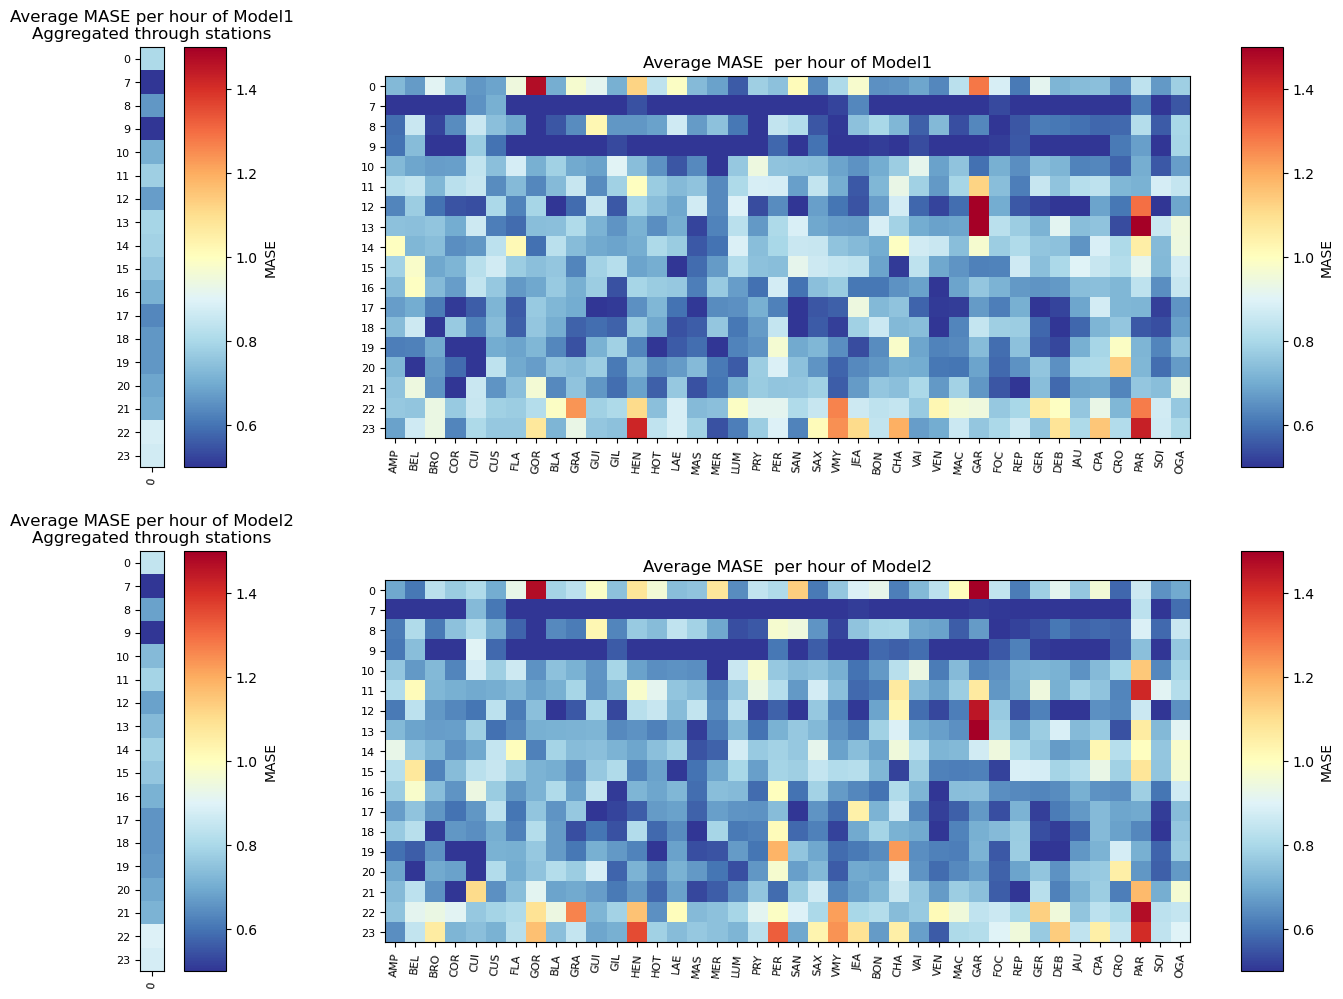

In [10]:
stations = list(ds1.spatial_unit)  # ['BEL','PER','PAR','AMP','FOC'] #list(ds1.spatial_unit)
temporal_aggs = ['hour'] #['weekday_hour_minute','weekday_hour','hour','date','weekday']
for temporal_agg in temporal_aggs:
    fig, axes = plt.subplots(2, 2, figsize=(max(8,0.5*len(stations)),get_y_size_from_temporal_agg(temporal_agg)),gridspec_kw={'width_ratios': [2,5]})
    df_mase1,df_mase2,df_gain21 = get_df_mase_and_gains(ds1,dic_error,training_mode,temporal_agg,stations)
    for i,df_mase in enumerate([df_mase1,df_mase2]):
        # agg All sations  
        plt.sca(axes[i,0])
        plot_coverage_matshow(pd.DataFrame(pd.DataFrame(df_mase).mean(axis=1)),cmap = 'RdYlBu', save=None, 
                            cbar_label='MASE',bool_reversed=True,v_min=0.5,v_max=1.5)
        title = f'Average MASE per {temporal_agg} of Model{i+1}\nAggregated through stations'
        axes[i,0].set_title(title)

        # Per station 
        plt.sca(axes[i,1])
        plot_coverage_matshow(pd.DataFrame(df_mase),cmap = 'RdYlBu', save=None, 
                            cbar_label='MASE',bool_reversed=True,v_min=0.5,v_max=1.5)
        title = f'Average MASE  per {temporal_agg} of Model{i+1}'
        axes[i,1].set_title(title) 


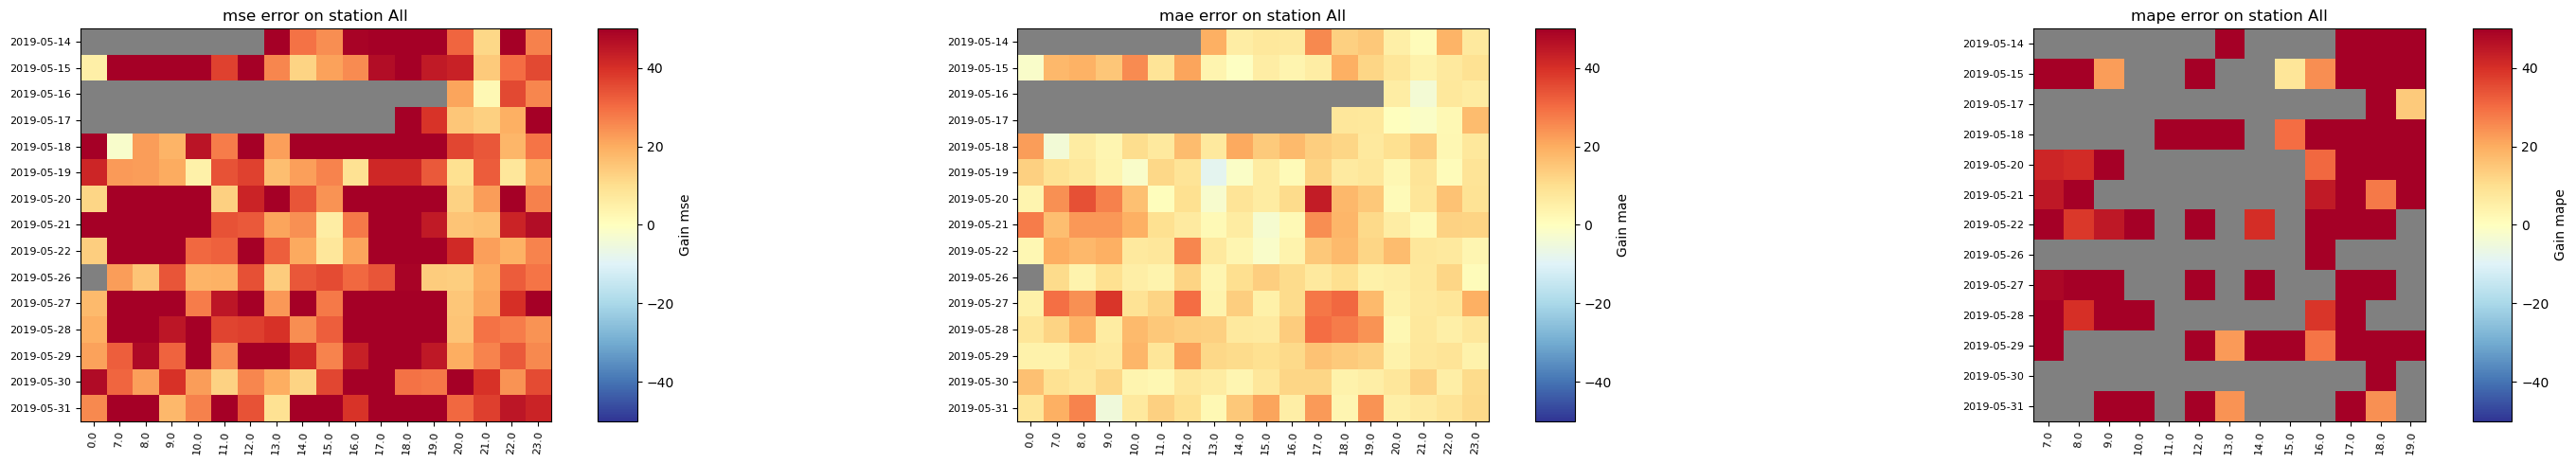

(<Figure size 3000x500 with 6 Axes>,
 array([<Axes: title={'center': 'mse error on station All'}>,
        <Axes: title={'center': 'mae error on station All'}>,
        <Axes: title={'center': 'mape error on station All'}>],
       dtype=object))

In [11]:
station = ['PAR','PER','GER','BON']
training_mode = 'test'

# index_matshow in :  ['weekday','hour','month_year','date','day_date']
# columns_matshow in :  [None, 'weekday','hour','month_year','date','day_date']

gain_between_models(trainer1,trainer2,ds1,ds2,training_mode,
                         metrics = ['mse','mae','mape'],
                        freq='1h',
                        index_matshow = 'date',
                        columns_matshow = 'hour',
                        min_flow = 20,
                        limit_percentage_error = 50,
                        acceptable_error = 10,
                        stations = station,
                        plot_each_station = False,
                        plot_all_station = True)

## Visualisation des coeff d'attentions :

In [ ]:
from plotting.plotting import plot_attn_weight
from constants.paths import CALENDAR_TYPE
nb_calendar_data = len(CALENDAR_TYPE)
temporal_agg = 'hour'  # weekday_hour_minutes','hour','weekday','weekday_hour'
training_mode = 'test'
station = ['CHA','PAR','PER']
plot_attn_weight(trainer,nb_calendar_data,ds,training_mode = training_mode,stations= station,temporal_agg =temporal_agg,save=None)

In [3]:
save_folder1 = 'K_fold_validation/training_with_HP_tuning/'
add_name_id1 = ''
trial_id1 ='subway_in_subway_out_STGCN_MSELoss_2025_02_20_22_43_85017'
trainer,ds,args = get_trainer_and_ds_from_saved_trial(trial_id1,add_name_id1,save_folder1,modification={})

>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
nb subway_in invalid dates:  776
T_subway_out:  torch.Size([7392, 40])
vision_input_type POIs
vision_model_name None
2821 train samples had been added thank to Data Augmentation
calendar data augmented by dupplication but not modified
Train/Target size:  torch.Size([5642, 40, 7]) torch.Size([5642, 40, 1])
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 5642 940 940

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Invalid dates within this fold: 481
Considered Spatial-Unit:  Index(['AMP', 'BEL', 'BRO', 'COR', 'CUI', 'CUS', 'FLA', 'GOR', 'BLA', 'GRA',
       'GUI', 'GIL', 'HEN', 'HOT', 'LAE', 'MAS', 'MER', 'LUM', 'PRY', 'PER',
       'SAN', 'SAX', 'VMY', 'JEA',

In [6]:
layer = 0
training_mode = 'test'
attn_model = trainer.model.core_model.output.temporal_agg.layers[layer].attention.sublayer.heads
num_heads = len(attn_model)

X,Y,X_c,nb_contextual = trainer.load_all_inputs_from_training_mode(training_mode)

In [11]:
import gc
import torch.nn as nn 
gc.collect()
torch.cuda.empty_cache()

original_temporal_agg = trainer.model.core_model.output.temporal_agg
model_until_temporal_MHA = trainer.model
model_until_temporal_MHA.core_model.output.temporal_agg = nn.Identity()


trainer.model.eval()
with torch.no_grad():
    intermediate_output = model_until_temporal_MHA(X,X_c)

gc.collect()
torch.cuda.empty_cache()

In [12]:
intermediate_output.size()

torch.Size([940, 40, 1])

In [ ]:

for head in attn_model:
    enhanced_x,attn_weights = head(X,X_c)

In [ ]:
def plot_attn_weight(trainer,nb_calendar_data,ds= None,training_mode = None,temporal_agg = None,save=None,stations= None,layer = None):
    attn_model = trainer.model.core_model.output.temporal_agg.layers[layer].attention.sublayer.heads
    num_heads = len(attn_model)
    
    X,Y,X_c,nb_contextual = trainer.load_all_inputs_from_training_mode(training_mode)

    # Init:
    nb_contextuals = len(X_c) - nb_calendar_data
    spatial_units = list(ds.spatial_unit)
    if stations is not None :
        nb_stations_to_plot = len(stations) 
    else :
        stations = list(ds.spatial_unit)
        nb_stations_to_plot = Y.size(1)
    num_cols = 4

    nb_rows = (nb_stations_to_plot*num_heads + num_cols - 1) // num_cols  
    y_size = get_y_size_from_temporal_agg(temporal_agg)
    #plt.figure(figsize=(5*num_cols,y_size))  
    plt.figure(figsize=(5*num_cols*max(1,nb_stations_to_plot//15),int(y_size*max(1,nb_contextuals//num_cols))))

    vmin,vmax = 0,min(1,1/(nb_contextuals/3)) 
    for station_i in range(nb_stations_to_plot):

        station_ind  = spatial_units.index(stations[station_i])

        enhanced_x,attn_weights = attn_model[station_ind](X[:,station_ind,:],X_c[station_ind+nb_calendar_data],x_known = None)
        if attn_weights.dim()==4:
            for attn_head_i in range(num_heads):
                attn_weights_reshaped = attn_weights[:,attn_head_i,:,:].squeeze(1).detach().cpu().numpy()  # Shape [B, P]
                # Temporal Aggregation of attn weight:
                attn_weights_reshaped,str_dates = temporal_aggregation_of_attn_weight(attn_weights_reshaped,ds,training_mode,temporal_agg)
                ax = plt.subplot(nb_rows, num_cols, station_i*num_heads+attn_head_i + 1)  # Créer un subplot
                im = ax.imshow(attn_weights_reshaped, cmap='hot', aspect='auto',vmin=vmin,vmax=vmax)
                plt.colorbar(im,label='Attention Weight',shrink = 0.25)
                
                if temporal_agg is None:
                    plt.title(f'Attention Weight head {attn_head_i}\nof station {station_ind} ({spatial_units[station_ind]}) \nfor each sample of the batch')
                    plt.ylabel('Samples')
                else:
                    plt.title(f'Mean Attention Weight head {attn_head_i}\nof station {station_i}({spatial_units[station_ind]}) \nby calendar class') 
                    plt.ylabel('Calendar class')
                plt.xlabel('Contextual time-series')


                num_samples, nb_contextual_on_plot_i = attn_weights_reshaped.shape
                plt.xticks(ticks=np.arange(nb_contextual_on_plot_i), labels=[f'Unit {i}' for i in range(nb_contextual_on_plot_i)], rotation=45)
                plt.yticks(ticks=np.arange(num_samples), labels=str_dates)

    plt.tight_layout()

    if save is not None:
        plt.savefig(f'{save}.pdf',format = 'pdf',bbox_inches='tight')
    plt.show()

## Fine Tuning on Specific Moments : 
- !!! ICI besoin de 'shuffle = True' parce qu'on train le model (fine-tuning)

## Fly-by transit:
#### Concept existants:
- Stop-Less Autonomous Modular (SLAM) (testé à dubai en 2018) : micro bus qui peuvent se concatener si besoin (opour en faire des plus gros), et qui sont indépendant également si beson . Permet de distribuer correctement les usagers selon leur destinations. A Dubai: 6 seats et 4 debout par mini bus (capacity 10).
L'idée c'est d'arrêter de faire des stops. 
- AMB aussi à produit des prototype du henre.

Limite dans le cas d'utilisation 'massive': pas inclusif, les vieux peuvent pas aler d'un module à un autre. Même pour marcher entre deux module c'est pas incroyable. Puis dans tout les cas on a jamais 2 passagers qui ont les mêmes OD. 
#### Leur proposition: 
proposer leur propre model mais en préservant la dimension 'transport public'. 
Propose de décomposer en tout petit moduel, pour 1 a 2 personne. Pouvant se mettre par exemple en platoon etc.
## Question : 
- que faire dnas le cas où bu va d'un point A à un point B, dont la majorité de ses usagers font ce trajet ?
- Enormement de 'sous module': technologie embarquée, seat à laver après chaque utilisation/journée, réparation etc... finalement pas de coût de driver mais énormément d'autres coûts, s'assurer en permanance de la sécurité de chaque unité (high speed, donc dangereux), les réparations etc...
- Utilisation de la capacité 'urbaine': acutellement beaucoup de congestion. ça ne devrait pas les aider, d'autant plus que si on permet à tout le monde de se déplacer ça va encourager des 'micro' déplacement', qui prennent de la place sur le réseau (contrairement à des mobilités douces types vélo, ou contrairement a des gros system de transport type metro / bus grande capacité).
- C'est moins cher que le Taxi par personne transporté. Mais on ne veut pas un taxi par personne.  comparaiosn avec un model non souhaitable.
- Compare le prix avec une voiture éléctrique. Mais la on parle d'un truc autonome.
- Surement des moment et endroit où quand la demande est importante, il y a aura des centaines de Trailers qui devront se déplacer au même endroit, et ça va générer d'énorme problème logistique.


## Benchmark Comparison between models: 

In [1]:
import pandas as pd
from examples.benchmark import local_get_args,keep_track_on_model_metrics
from examples.train_and_visu_non_recurrent import train_the_config,get_ds_without_shuffling_on_train_set
from plotting.TS_analysis import plot_TS


def get_TS_prediction(trainer,ds,stations_to_plot='CHA',training_mode='test',name= ''):
    spatial_units  = list(ds.spatial_unit)
    station_indices = [spatial_units.index(station) for station in stations_to_plot]
    predict,Y_true,_ = trainer.testing(ds.normalizer, training_mode =training_mode)
    df_pred =  pd.DataFrame({f'{name}_{spatial_units[station_i]}_Pred':predict[:,station_i,0].detach().cpu().numpy() for station_i in station_indices})
    df_true = pd.DataFrame({f'{spatial_units[station_i]}_Y_true': Y_true[:,station_i,0].detach().cpu().numpy() for station_i in station_indices})
    index_df = getattr(ds.tensor_limits_keeper,f"df_verif_{training_mode}").iloc[:,-1].values
    return df_pred,df_true,index_df

Training and Hyper-parameter tuning with Ray is not possible


Training and Hyper-parameter tuning with Ray is not possible
>>>>Model: CNN; K_fold = 6; Loss function: MSE 
>>>>Model: CNN; K_fold = 6; Loss function: MSE 
Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
nb subway_in invalid dates:  776
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 2821 940 940
Considered Spatial-Unit:  None
Model size: 0.000GB
number of total parameters: 1889
number of trainable parameters: 1889

start training
epoch: 0 
 min\epoch : 0.08
Estimated time for training: 2.0min 

Training Throughput:3139.53 sequences per seconds
>>> Training complete in: 0:01:56.890262
>>> Training performance time: min 0.00694584846496582 avg 0.009059906005859375 seconds (+/- 0.006282888286802044)
>>> Loading performance time: min 0.00015854835510253906 avg 0.0062623259501425775 seconds (+/- 0.014081617299986991)
>>> Forward performance time: 0.0009820986656757377 sec

Loading BokehJS ...

<Axes: >

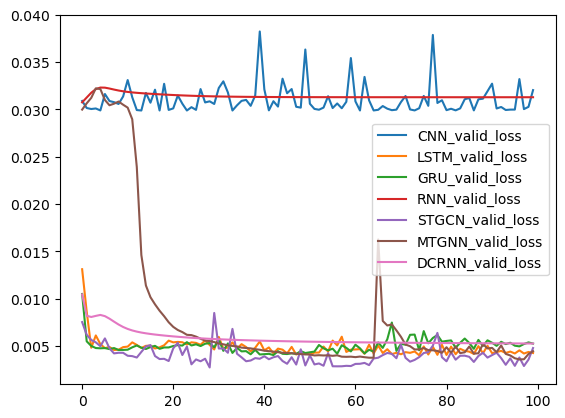

In [1]:
dataset_for_coverage = ['subway_in','netmob_POIs']
dataset_names = ['subway_in']
save_folder = 'benchmark/fold0/'
df_results,df_loss_tot,df_pred_all_models = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

modification = {'epochs' : 100, #100,
                'hp_tuning_on_first_fold': False,
                'keep_best_weights':True

                }

stations_to_plot = ['CHA']
training_mode = 'test'
model_names =['CNN','LSTM','GRU','RNN','STGCN','MTGNN','DCRNN']   # Attention Graph ???
dict_trainers = {}
for model_name in model_names:
    args = local_get_args(model_name,
                            args_init = None,
                            dataset_names=dataset_names,
                            dataset_for_coverage=dataset_for_coverage,
                            modification = modification)
    fold_to_evaluate = [args.K_fold -1]
    trainer,ds,args,trial_id,df_loss = train_the_config(args,modification,fold_to_evaluate)
    trainer,ds_no_shuffle = get_ds_without_shuffling_on_train_set(trainer,modification,args,fold_to_evaluate)


    metrics = trainer.metrics
    df_results = keep_track_on_model_metrics(trainer,df_results,model_name,trainer.performance,trainer.metrics)
    #dict_trainers[model_name] = trainer
    # Get TS prediction on Test Dataset
    df_loss_tot = pd.concat([df_loss_tot,df_loss],axis=1)
    df_pred,df_true,index_df = get_TS_prediction(trainer,ds,stations_to_plot=stations_to_plot,training_mode=training_mode,name= model_name)
    df_pred_all_models = pd.concat([df_pred_all_models,df_pred],axis=1)
    print(df_results)

# Concat with 'Y_true'
df_pred_all_models = pd.concat([df_pred_all_models,df_true],axis=1)
df_pred_all_models.index = index_df
plot_TS(df_pred_all_models,width=1400,height=400,bool_show=True,title='Comparison of Prediction Quality')

df_loss_tot[[f"{model}_valid_loss" for model in model_names]].plot()


In [2]:
df_results

,Model,Valid_loss,Valid_mse,Test_mse,Valid_mae,Test_mae,Valid_mape,Test_mape
0,CNN,0.029883,18683.888672,17581.490234,92.898766,87.686371,284.523895,218.150238
0,LSTM,0.004042,2056.194824,2027.486328,27.648268,27.326344,40.493713,36.615929
0,GRU,0.004063,2078.000488,2051.144531,27.521818,27.205008,45.601322,40.368877
0,RNN,0.030743,19329.923828,18687.574219,90.831963,86.728508,242.366821,185.635788
0,STGCN,0.002752,1368.745239,1421.312134,22.125439,22.203094,38.124065,34.790466
0,MTGNN,0.003603,1870.807617,1942.013184,26.149363,26.374453,46.093781,40.294285
0,DCRNN,0.005282,2824.918213,2873.498779,31.813610,32.829212,57.927681,54.280727


>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
>>>>Model: STGCN; K_fold = 6; Loss function: MSE 


Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
nb subway_in invalid dates:  776
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 2821 940 940
Considered Spatial-Unit:  None
Model size: 0.000GB
number of total parameters: 71713
number of trainable parameters: 71713

start training
epoch: 0 
 min\epoch : 1.29
Estimated time for training: 18.8min 

Training Throughput:692.55 sequences per seconds
>>> Training complete in: 0:05:10.429930
>>> Training performance time: min 0.014720678329467773 avg 0.02728891372680664 seconds (+/- 0.06569723933859964)
>>> Loading performance time: min 0.00013709068298339844 avg 0.03701392448955633 seconds (+/- 0.6139421012670077)
>>> Forward performance time: 0.031157050568967972 seconds (+/- 0.06124145142530242)
>>> Backward performance time: 0.007092571333569874 seconds (+/- 0.003103940249793853)
>>> Plotting performance time: 1.2173944590

Loading BokehJS ...

<Axes: >

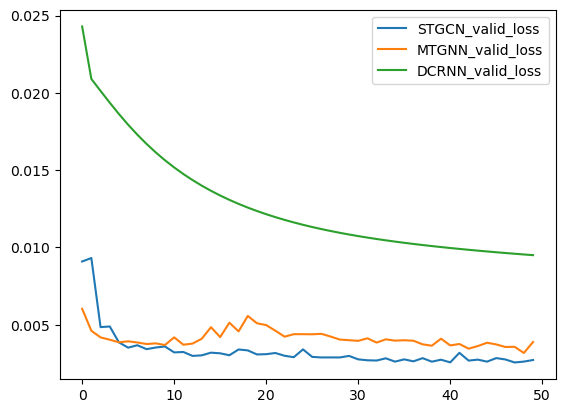

In [2]:
dataset_for_coverage = ['subway_in','netmob_POIs']
dataset_names = ['subway_in']
save_folder = 'benchmark/fold0/'

df_results,df_loss_tot,df_pred_all_models = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
modification = {'epochs' : 50, #100,
                'lr': 0.00135,
                'weight_decay': 0.0733390536333296,
                'batch_size': 32,
                'dropout': 0.3187398629441463,
                'scheduler': None,
                'hp_tuning_on_first_fold': False,
                'keep_best_weights':True
                }

stations_to_plot = ['CHA']
training_mode = 'test'
model_names =['STGCN','MTGNN','DCRNN']   # Attention Graph ???
dict_trainers = {}

for model_name in model_names:
    args = local_get_args(model_name,
                            args_init = None,
                            dataset_names=dataset_names,
                            dataset_for_coverage=dataset_for_coverage,
                            modification = modification)
    fold_to_evaluate = [args.K_fold -1]
    trainer,ds,args,trial_id,df_loss = train_the_config(args,modification,fold_to_evaluate)
    trainer,ds_no_shuffle = get_ds_without_shuffling_on_train_set(trainer,modification,args,fold_to_evaluate)


    metrics = trainer.metrics
    df_results = keep_track_on_model_metrics(trainer,df_results,model_name,trainer.performance,trainer.metrics)
    #dict_trainers[model_name] = trainer
    # Get TS prediction on Test Dataset
    df_loss_tot = pd.concat([df_loss_tot,df_loss],axis=1)
    df_pred,df_true,index_df = get_TS_prediction(trainer,ds,stations_to_plot=stations_to_plot,training_mode=training_mode,name= model_name)
    df_pred_all_models = pd.concat([df_pred_all_models,df_pred],axis=1)
    print(df_results)

# Concat with 'Y_true'
df_pred_all_models = pd.concat([df_pred_all_models,df_true],axis=1)
df_pred_all_models.index = index_df
plot_TS(df_pred_all_models,width=1400,height=400,bool_show=True,title='Comparison of Prediction Quality')

df_loss_tot[[f"{model}_valid_loss" for model in model_names]].plot()

In [7]:
from examples.load_best_config import load_args_of_a_specific_trial
add_name_id = ''
trial_id ='subway_in_STGCN_MSELoss_2025_01_20_14_27_20569'
save_folder = 'K_fold_validation/training_with_HP_tuning/re_validation'
fold_name = 'complete_dataset'
args = load_args_of_a_specific_trial(trial_id,add_name_id,save_folder,fold_name)
args.lr

0.00135

In [10]:
for arg_i in ['lr','weight_decay','batch_size','dropout','scheduler']:
    print(f"'{arg_i}': {getattr(args,arg_i)},")

'lr': 0.00135,
'weight_decay': 0.0733390536333296,
'batch_size': 32,
'dropout': 0.3187398629441463,
'scheduler': nan,
